# 22.46 Procesamiento Adaptativo de Señales Aleatorias
## Trabajo Práctico N° 3
## Predicción Lineal
En este trabajo se buscará aplicar la estimación lineal óptima al caso particular de predicción lineal de señales de voz.

#### Grupo N° 1
* Davidov, Gonzalo Joaquín
* Farall, Facundo David
* Kammann, Lucas Agustín
* Trozzo, Rafael Nicolás

# 1. Grabaciones de voz
En esta sección, se estudiarán, analizarán y observarán aquellas grabaciones de voz sobre las cuales se aplicará la predicción lineal. Para ello, se grabaron sonidos /a/ y /sh/ de una persona utilizando una frecuencia de muestreo $f_s = 16kHz$.

Los sonidos deben ser grabados de la forma más estable posible en el tiempo, porque se busca asegurar la estacionariedad de la señal aleatoria. Normalmente, la señal de voz es únicamente estacionaria de forma local a un intervalo (de aproximadamente $20 ms$). Si la grabación tuviera estas características, los estadísticos de la señal cambiarían y el predictor lineal debería actualizarse continuamente. Es por eso que una característica esperada de las señales empleadas, es la estacionariedad.

Otro aspecto observado, es que es necesario asegurarse que las muestras utilizadas para la predicción, no incluyan los silencios iniciales y finales. Por eso, se recortan las señales de audio para evitar que esos fragmentos perturben los resultados obtenidos.

In [703]:
import matplotlib.pyplot as plt

In [704]:
from scipy.io import wavfile

In [705]:
import numpy as np

In [706]:
import IPython

In [707]:
import seaborn as sns

In [708]:
sns.set_style('dark')
sns.set_context('paper')
sns.set_palette('flare')

In [709]:
def plot_sound_analysis(samples, fs):
    """ Plots the signal and its spectrogram used in the analysis of the signals employed
        for the linear prediction in further sections.
        @param samples Samples of the signal
        @param fs Sampling frequency
    """
    # Create the plots
    fig = plt.figure(figsize=(16, 11))
    ax1 = fig.add_axes([0.1, 0.55, 0.7, 0.2])
    ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.35])
    ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.35])
    
    # Plot the signal
    ax1.plot(samples, label='Señal')
    ax1.set_xlabel('$n$', fontsize=15)
    ax1.set_ylabel('$x(n)$', fontsize=15)
    ax1.set_xlim((0, len(samples)))
    ax1.grid()
    
    # Plot the spectrogram to visualize the stationarity
    spectrum, freqs, t, im = ax2.specgram(samples, Fs=fs, cmap='plasma')
    ax2.tick_params(labelsize=15)
    ax2.set_title('Espectrograma', fontsize=18)
    ax2.set_xlabel('$t$ [s]', fontsize=16)
    ax2.set_ylabel('$f$ [Hz]', fontsize=16)
    
    # Plot the colorbar
    plt.colorbar(mappable=im, cax=ax3)

    # Show the plots
    plt.show()

## 1.1. Sonido /a/

In [710]:
# Choose /a/ sound recording
rec_a_filename = '../resources/recording_a_06.wav'

In [711]:
# Read the /a/ .wav file
rec_a_fs, rec_a_samples = wavfile.read(rec_a_filename)

In [712]:
# Remove silence
rec_a_samples = rec_a_samples[50000:140000]

In [713]:
# Estimate the mean, use it to create a zero mean random signal
# and normalize the signal using its standard deviation
rec_a_mean = rec_a_samples.mean()
rec_a_std = rec_a_samples.std()
rec_a_samples = (rec_a_samples - rec_a_mean) / rec_a_std

In [714]:
# Play the recorded sound
IPython.display.Audio(rec_a_samples, rate=rec_a_fs)

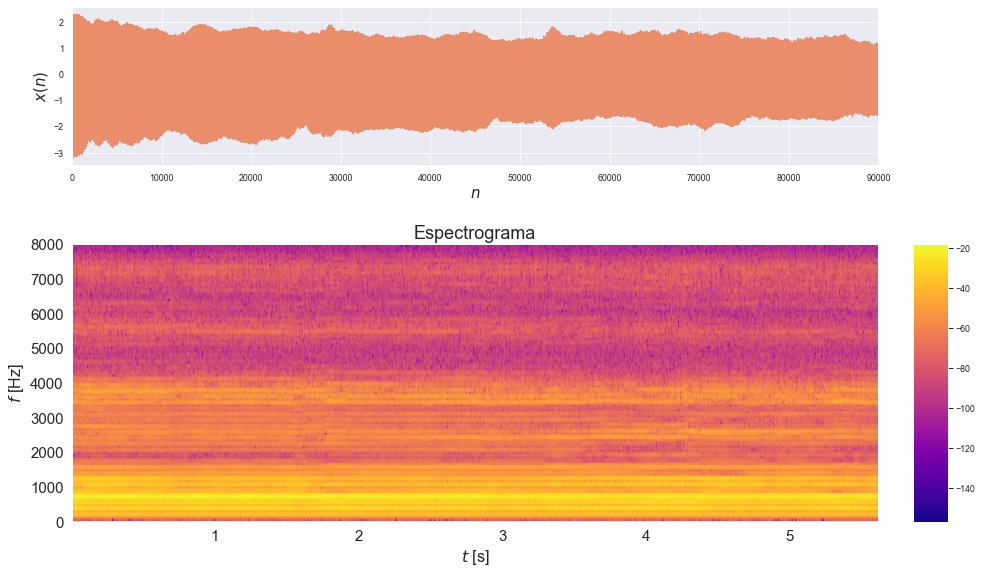

In [715]:
# Plot the analysis for the /a/ sound
plot_sound_analysis(rec_a_samples, rec_a_fs)

### 1.2. Sonido /sh/

In [716]:
# Choose /sh/ sound recording
rec_sh_filename = '../resources/recording_sh_06.wav'

In [717]:
# Read the /sh/ .wav file
rec_sh_fs, rec_sh_samples = wavfile.read(rec_sh_filename)

In [718]:
# Remove silence
rec_sh_samples = rec_sh_samples[20000:100000]

In [719]:
# Estimate the mean, use it to create a zero mean random signal
# and normalize the signal using its standard deviation
rec_sh_mean = rec_sh_samples.mean()
rec_sh_std = rec_sh_samples.std()
rec_sh_samples = (rec_sh_samples - rec_sh_mean) / rec_sh_std

In [720]:
# Play the recorded sound
IPython.display.Audio(rec_sh_samples, rate=rec_sh_fs)

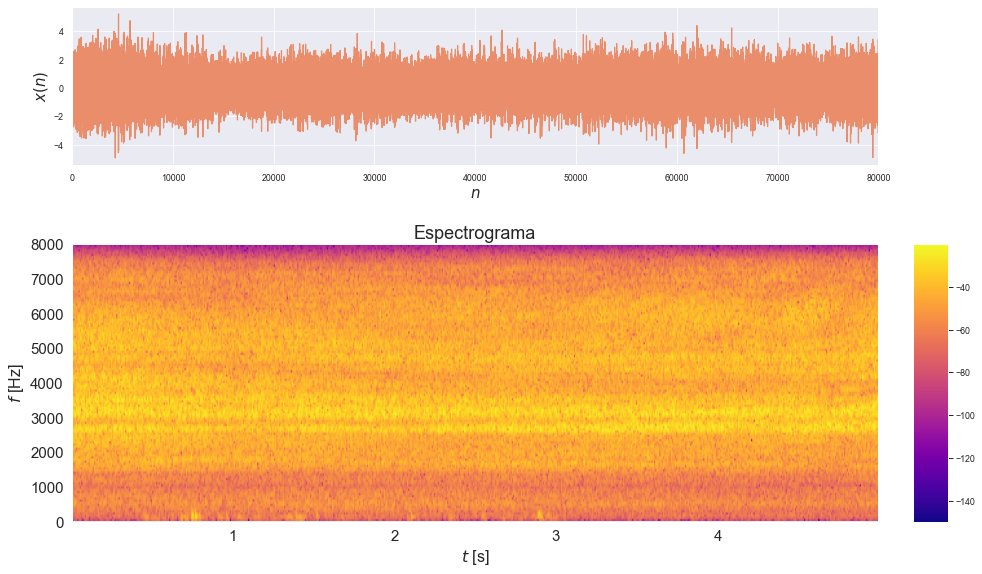

In [721]:
# Plot the analysis for the /a/ sound
plot_sound_analysis(rec_sh_samples, rec_sh_fs)

Observando el espectrograma del sonido /sh/ grabado, se puede concluir que tiene un espectro que contiene casi todas las frecuencias (dentro del espacio de frecuencias disponible por el dominio digital). Además, la densidad en cada frecuencia es elevada y similar para un amplio rango de frecuencias. Esta característica de tener una densidad espectral de potencia similar en ciertas frecuencias, y por la forma sonora del /sh/, se puede relacionar con una forma de ruido blanco. 

## 2. Predicción lineal forward

In [722]:
from statsmodels.tsa import stattools

In [723]:
from scipy import signal

In [724]:
def estimate_correlation(x, one_sided=True):
    """ Estimates the autocorrelation function of the input signal.
        @param x Input signal x(n)
        @return rxx
    """
    # Estimate the autocorrelation using the biased estimator
    rxx = signal.correlate(x, x, method='fft') / len(x)
    if one_sided:
        rxx = rxx[len(rxx)//2:]
    return rxx

In [740]:
def levinson_durbin(rxx):
    """ Computes the Levinson-Durbin algorithm to calculate the coefficients of an M order
        linear predictor, using the provided autocorrelation function.
        @param rxx Autocorrelation [rxx(0), rxx(1), ..., rxx(M)]
        @return (ao, J) -> Linear predictor coefficients and residual MSE of each order
    """
    # Compute the algorithm using a third-party library
    # and complete the missing values
    _, ao, _, J, _ = stattools.levinson_durbin(rxx, nlags=len(rxx)-1, isacov=True)
    J[0] = rxx[0]
    
    # Return the result
    return -ao, J

In [741]:
def optimum_linear_predictor(x, order):
    """ Get the optimum linear predictor for the random signal.
        @param x Random signal to predict
        @param order Order of the predictor
        @return (ao, J) -> Linear predictor coefficients and residual MSE of each order
    """
    # Estimate the autocorrelation
    rxx = estimate_correlation(x, one_sided=True)
    
    # Calculate the predictor using the Levinson-Durbin algorithm
    return levinson_durbin(rxx[:order+1])

In [879]:
def get_error_filter(coefficients):
    """ Get the error filter from the linear predictor coefficients.
        @param coefficients Coefficients of the linear predictor
        @return Coefficients of the error filter (FIR)
    """
    return np.concatenate(([1.0], coefficients))

In [849]:
def plot_mse_analysis(x, order, title):
    """ Plot the residual MSE when using the optimum linear predictor for the input signal, using different orders.
        @param x Random signal to predict
        @param order Maximum order to use
        @param title Title for the plot
    """
    # Compute the coefficients and residuals
    coefficients, residuals = optimum_linear_predictor(x, order)
    
    # Plot the results
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    fig.suptitle(title, fontsize=18)
    ax.semilogy(np.linspace(1, len(residuals[1:]), len(residuals[1:])), residuals[1:], color='red', label='MSE residual')
    ax.tick_params(labelsize=15)
    ax.set_ylabel('$\hat{J}_o$', fontsize=16)
    ax.set_xlabel('$M$', fontsize=16)
    ax.legend(fontsize=15)
    ax.grid()
    plt.show()

## 2.1. Graficando $J(M)$ para ambos sonidos

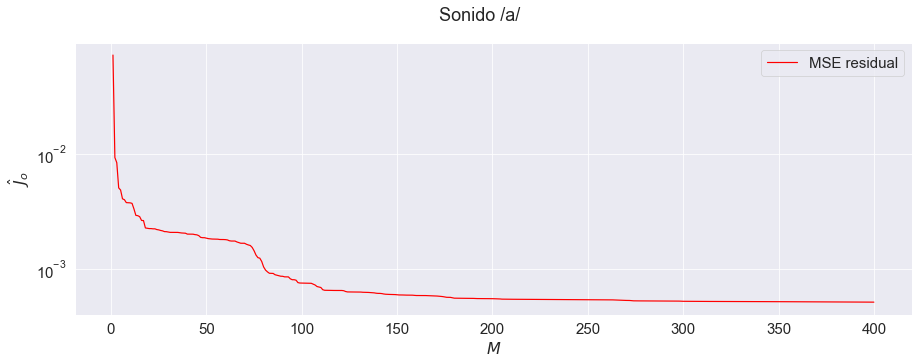

In [852]:
plot_mse_analysis(rec_a_samples, 400, 'Sonido /a/')

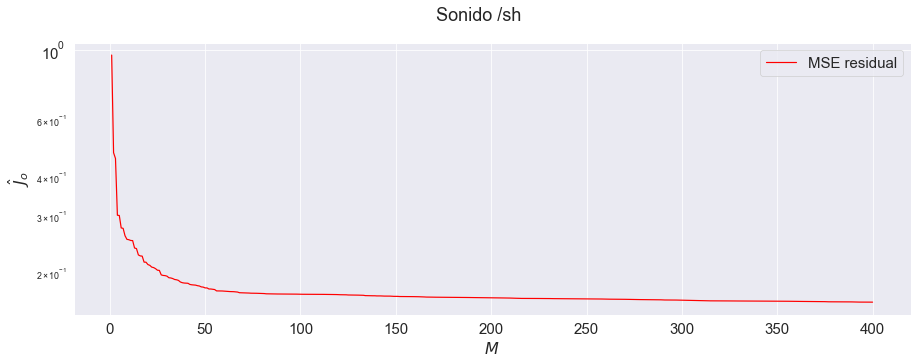

In [853]:
plot_mse_analysis(rec_sh_samples, 400, 'Sonido /sh')

## 2.2. Análisis de los resultados
